In [186]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, root_mean_squared_error, classification_report
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.datasets import make_classification, make_regression

In [109]:
%config InlineBackend.figure_format = 'retina'

sns.set_theme(style='whitegrid', palette='pastel')

plt.rcParams['axes.spines.left'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.bottom'] = False
plt.rcParams['figure.frameon'] = False

# Классификация

### Генерируем данные

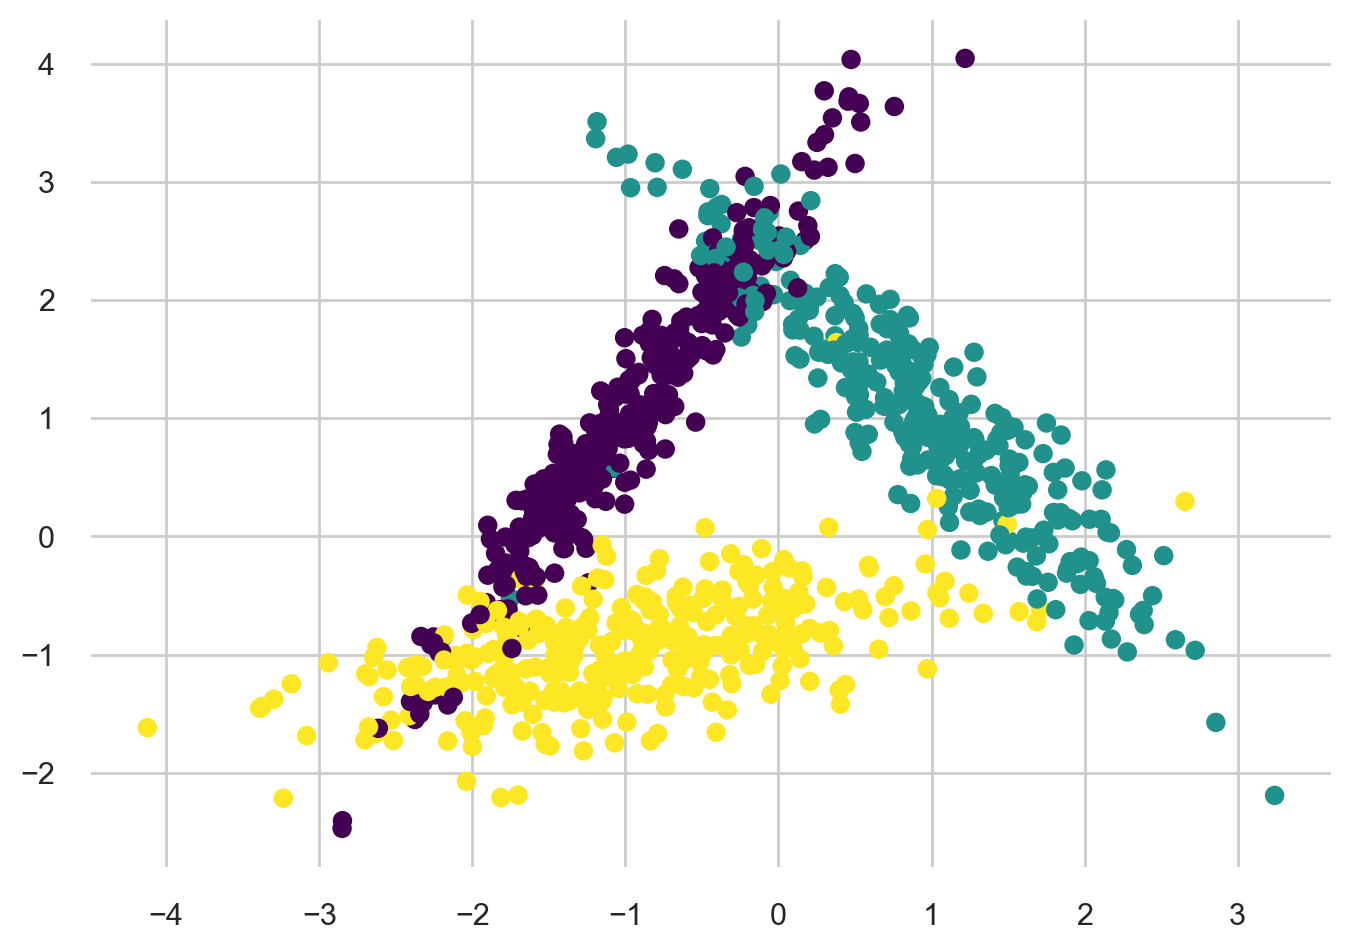

In [178]:
X, y = make_classification(
    n_samples=1000,
    n_features=2,
    n_informative=2,
    n_redundant=0,
    n_classes=3,
    n_clusters_per_class=1,
    random_state=42
)
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X,y,test_size=0.2)
plt.scatter(X[:, 0], X[:, 1],  c=y, cmap='viridis')
plt.savefig('class.png')

### Алгоритм

In [152]:
class KnnClassifier:
    def __init__(self, k_neighbors = 5, metric = "euclidean", weights = "uniform", h = 1, kernel_name="gauss"):
        self.k = k_neighbors
        self.metric = metric
        self.weights = weights
        self.h = h
        self.kernel_name = kernel_name

        if h == 0:
            raise ValueError("h can't be zero")
    
    def gauss_kernel(self, x):
        return (2 * np.pi) ** -0.5 * np.exp(-0.5 * x ** 2)
    
    def kernel(self, x):
        if self.kernel_name == "gauss":
            return self.gauss_kernel(x)
        else:
            raise ValueError
        

    def mode(self, arr:list):
        max_c = -1e9
        arg_max = 0

        for label in set(self.labels):
            c = 0
            for distance1, label1 in arr:
                if label == label1:
                    if self.weights == "uniform":
                        c += 1
            
                    elif self.weights == "distance":
                        weight = self.kernel(distance1 / self.h) 
                        c += weight
            
                    else:
                        raise ValueError

            if c > max_c:
                max_c = c
                arg_max = label
            
        return arg_max
    

    def euclidean_distance(self, x, z):
        s = 0
        for i in range(len(x)):
            s += (x[i] - z[i]) ** 2
        return s ** 0.5
    

    def manhattan_distance(self,x,z):
        s = 0
        for i in range(len(x)):
            s += abs(x[i] - z[i])
        return s


    def calculate_distance(self, x, z):
        if self.metric == "euclidean":
            return self.euclidean_distance(x, z)

        elif self.metric == "manhattan":
            return self.manhattan_distance(x,z)
        else:
            raise ValueError("Metric can be only 'euclidean' or 'manhattan'")


    def calculate_distances_to_all_objects(self, new_object):
        distances = []

        for i in range(len(self.points)):
            distance = self.calculate_distance(new_object, self.points[i])
            distances.append((distance, self.labels[i]))

        return distances


    def fit(self, points, labels):
        self.points = points
        self.labels = labels


    def predict(self, new_objects):
        predictions = []
        for object in new_objects:
            sorted_points = sorted(self.calculate_distances_to_all_objects(object))
            top_k_labels = sorted_points[:self.k]
            predictions.append(self.mode(top_k_labels))
        return predictions

In [179]:
knn_clf = KnnClassifier(5, metric='manhattan')
knn_clf.fit(np.array(X_train_clf), np.array(y_train_clf))

preds_clf = knn_clf.predict(np.array(X_test_clf))

### Метрики и визуализация

In [180]:
pd.DataFrame(classification_report(preds_clf, y_test_clf, output_dict=True))

,0,1,2,accuracy,macro avg,weighted avg
precision,0.784615,0.929577,0.968750,0.895,0.894314,0.900994
recall,0.894737,0.846154,0.953846,0.895,0.898246,0.895000
f1-score,0.836066,0.885906,0.961240,0.895,0.894404,0.896185
support,57.000000,78.000000,65.000000,0.895,200.000000,200.000000


In [181]:
right_or_no = []
for i in range(len(preds_clf)):
    if preds_clf[i] == y_test_clf[i]:
        right_or_no.append(0)
    else:
        right_or_no.append(1)

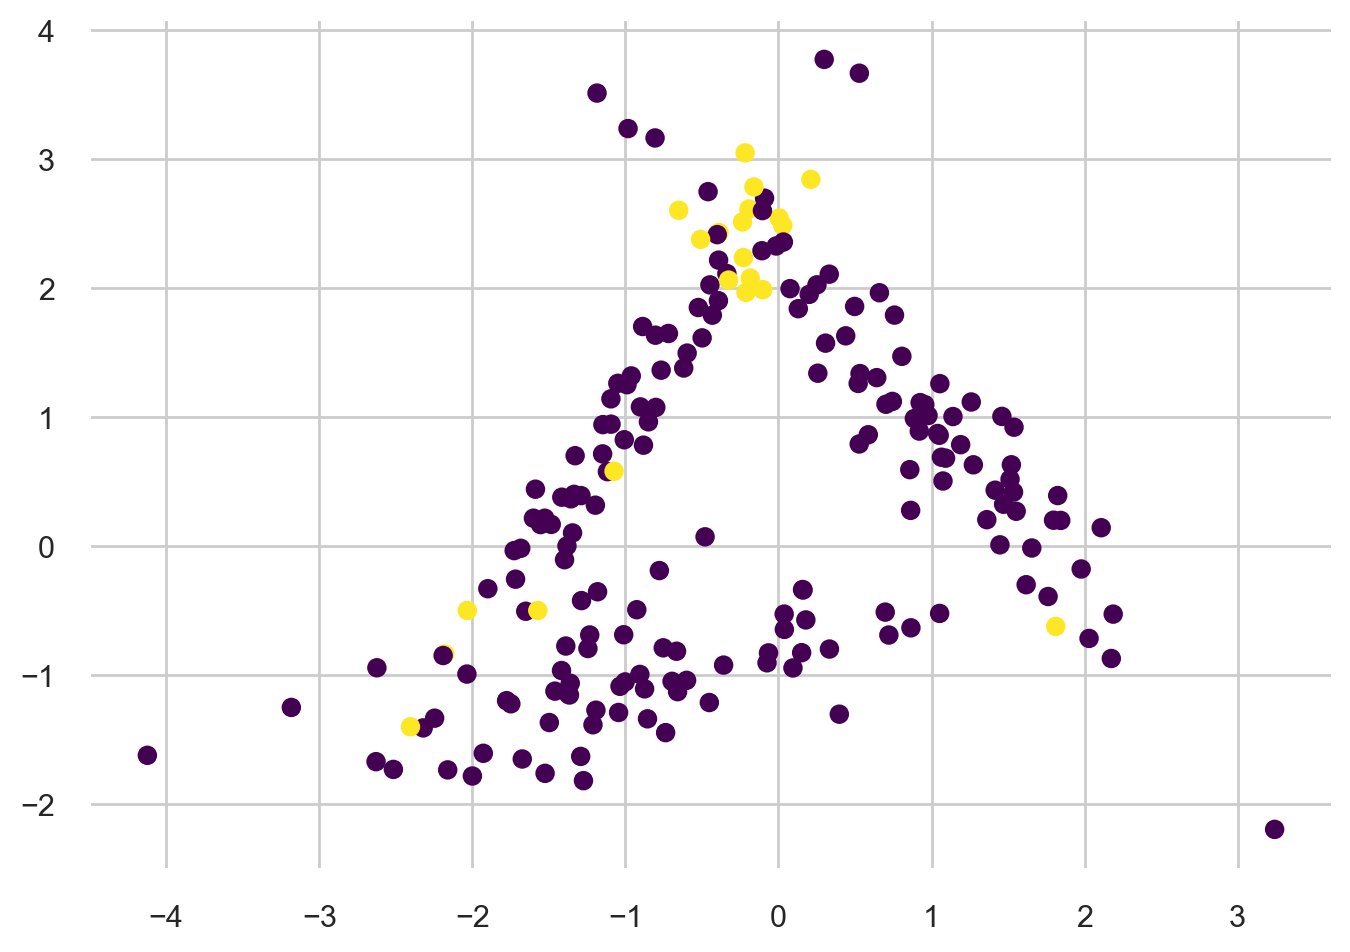

In [182]:
plt.scatter(X_test_clf[:, 0], X_test_clf[:, 1],  c=right_or_no, cmap='viridis')
plt.savefig('knn_errors.png')

### Сравнение с sklearn

In [158]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(5, weights='distance', metric='manhattan')
knn.fit(np.array(X_train_clf), np.array(y_train_clf))

preds_clf = knn.predict(np.array(X_test_clf))

In [183]:
right_or_no = []
for i in range(len(preds_clf)):
    if preds_clf[i] == y_test_clf[i]:
        right_or_no.append(0)
    else:
        right_or_no.append(1)

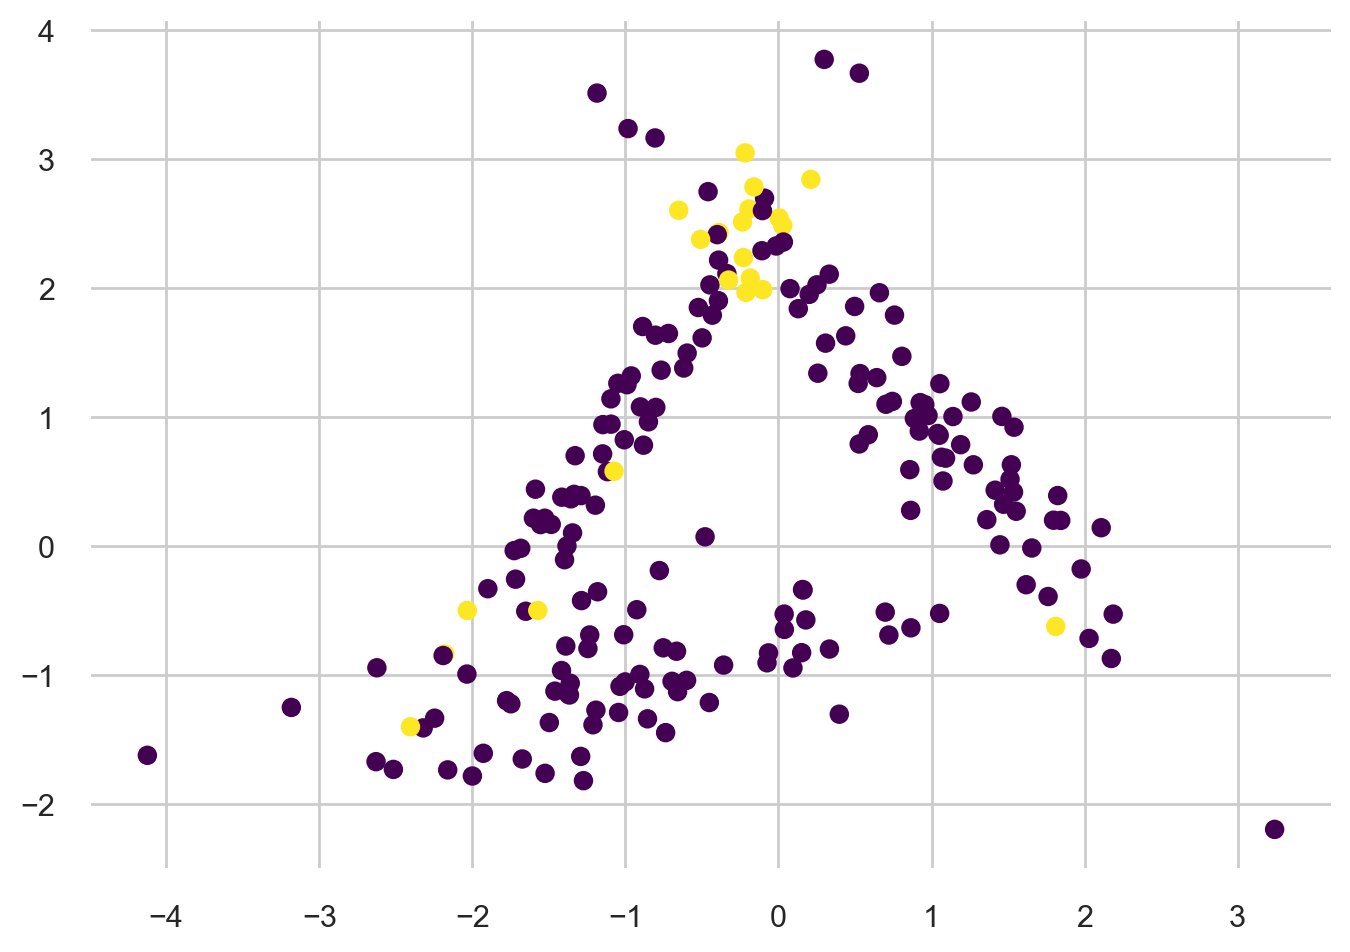

In [185]:
plt.scatter(X_test_clf[:, 0], X_test_clf[:, 1],  c=right_or_no, cmap='viridis')
plt.savefig('knn_errors.png')

# Регрессия

### Генерируем данные

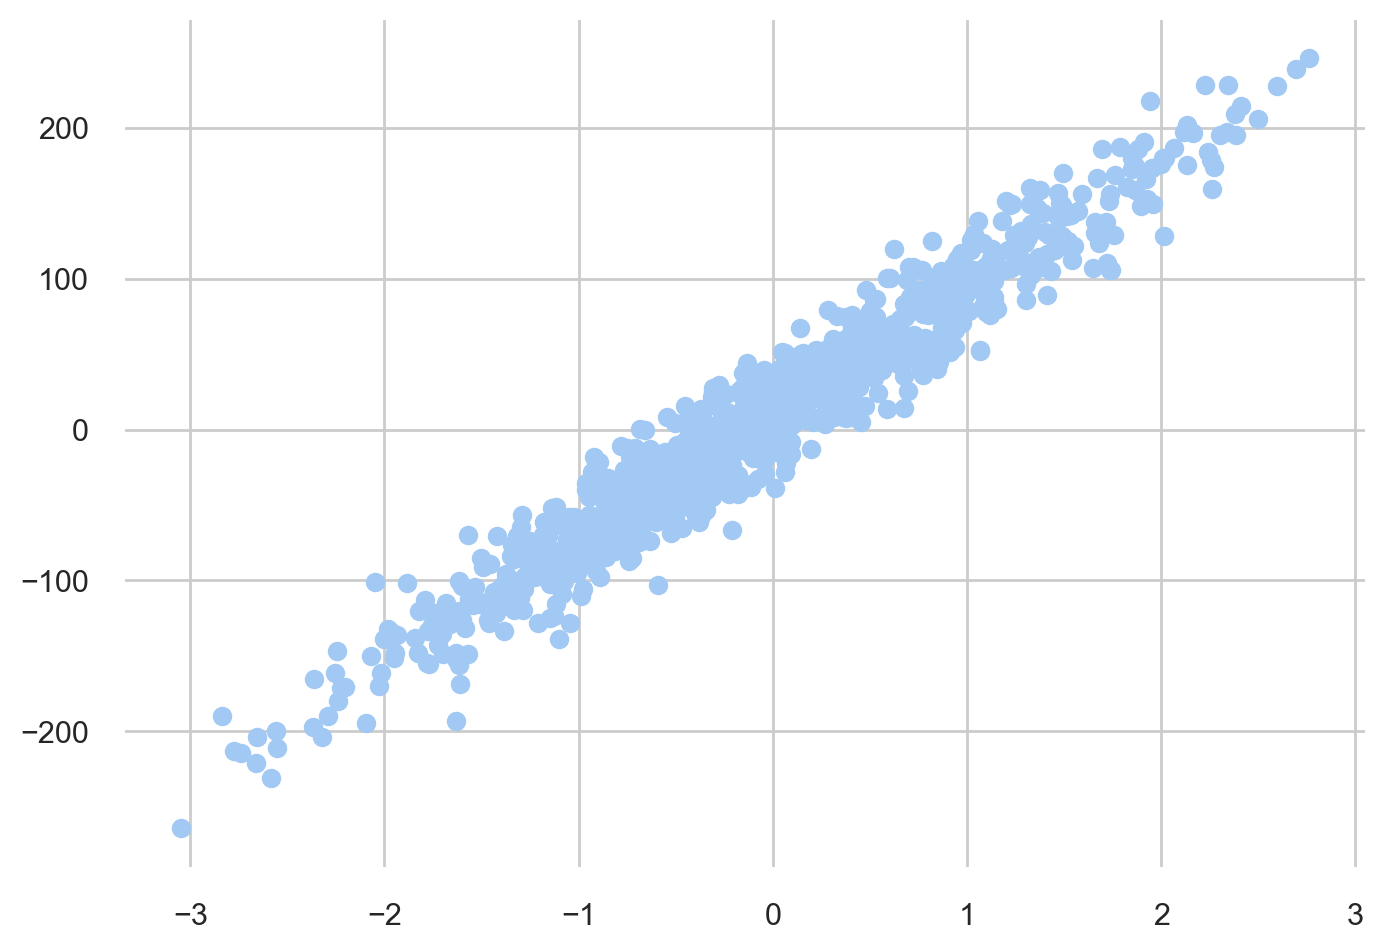

In [187]:
X,y, coef = make_regression(n_samples=1000,
                           n_features=1,
                           bias=10,
                           noise=20,
                           random_state=0,
                           coef=True
                           )
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X,y,test_size=0.2)
plt.scatter(X, y)

### Алгоритм

In [188]:
class KnnRegressor(KnnClassifier):
    def mode(self, arr:list):
        weights_sum = 0
        targets_sum = 0
        for distance, target in arr:
            weight = self.kernel(distance / self.h)
            targets_sum += weight * target
            weights_sum += weight
        
        return targets_sum / weights_sum
    


knn_reg = KnnRegressor(5, metric='manhattan')
knn_reg.fit(np.array(X_train_reg), np.array(y_train_reg))

preds_reg = knn_reg.predict(np.array(X_test_reg))

### Метрики и визуализация

In [189]:
root_mean_squared_error(y_test_reg, preds_reg)

20.762644261201956

In [190]:
r2_score(y_test_reg, preds_reg)

0.9362964624509829

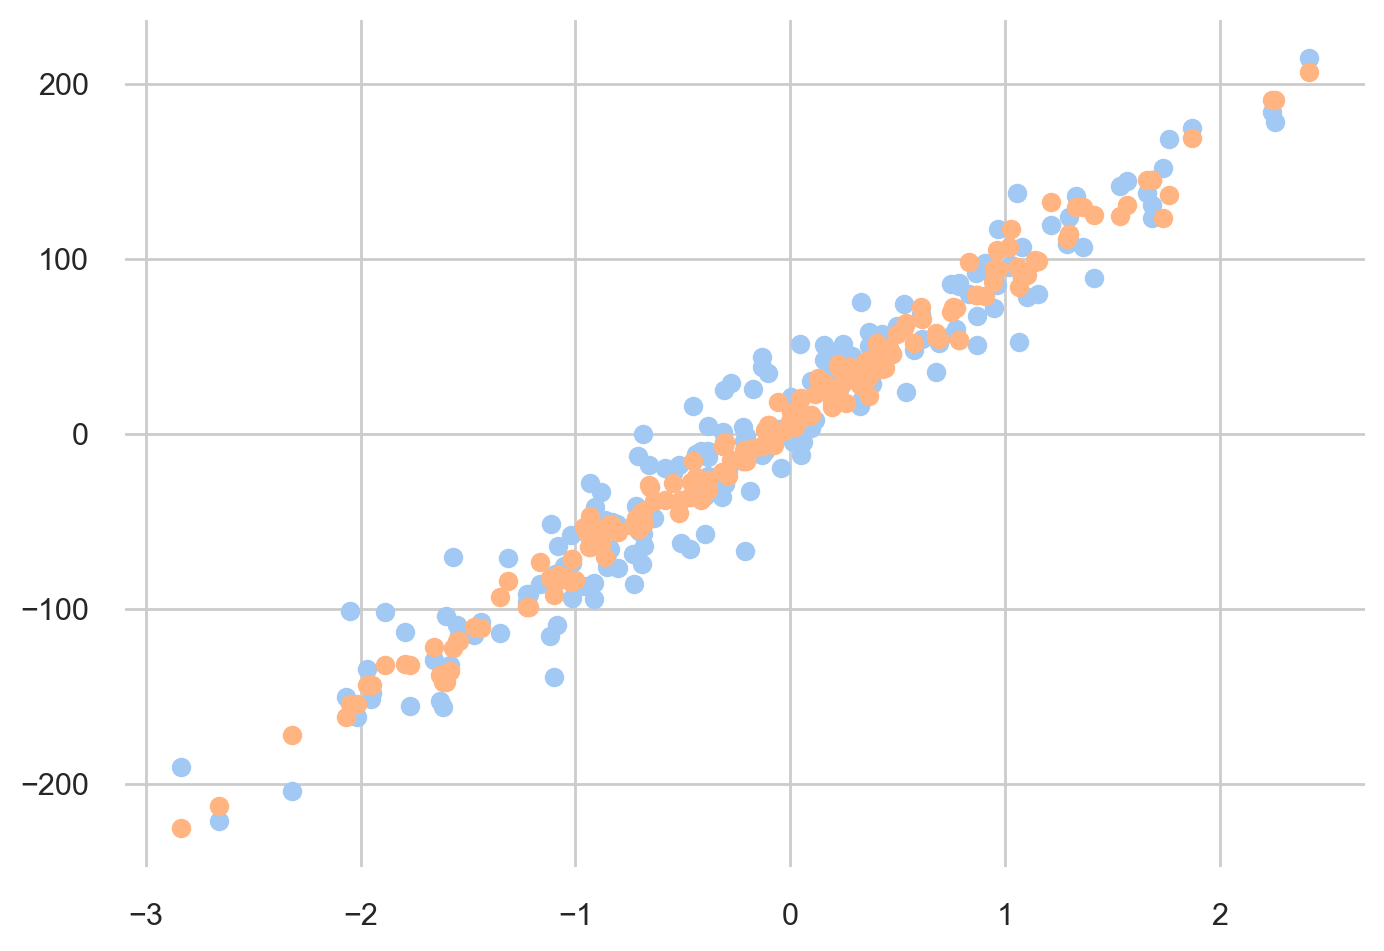

In [191]:
plt.scatter(X_test_reg, y_test_reg)
plt.scatter(X_test_reg, preds_reg)
plt.savefig("reg.png")

### Сравнение с sklearn

In [192]:
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(5, weights='distance', metric='manhattan')
knn.fit(np.array(X_train_reg), np.array(y_train_reg))

preds = knn.predict(np.array(X_test_reg))
preds


array([  71.78807858,  -62.20766263,   56.9685314 ,   -8.71128104,
        -47.53699727,   38.97258502,   29.49546246,   53.57588686,
         70.4853072 ,  -85.70217356, -175.90861541,   98.42999456,
        127.58177932,   32.36469037,   18.74215187,  107.81043495,
        205.328316  ,  -77.3095768 , -110.17923265,    0.25057825,
        -51.64143561,   35.67266547,  -97.78830048,   43.50158439,
        -16.70609534,  -30.719211  ,  192.62644999, -138.63485569,
        120.15581868,   42.39663694,   81.00842961,   57.71694159,
       -138.0022624 ,   91.07393654,  132.93674411,  129.46286238,
         12.09436425,  -10.45781444,  -78.472889  ,  -88.37924926,
        126.32627728,  -46.82321507,  -53.26511575,   -7.54734245,
        158.37846923,  102.58638328,  -75.54814564,   93.87728974,
        -51.88466087,  -20.90224877,  -80.67716852,  -81.91672806,
        -20.628711  ,  -28.09439334,  101.02524883,  -74.18450342,
         25.2059134 ,  -47.3908513 ,   47.55879666,    9.36907

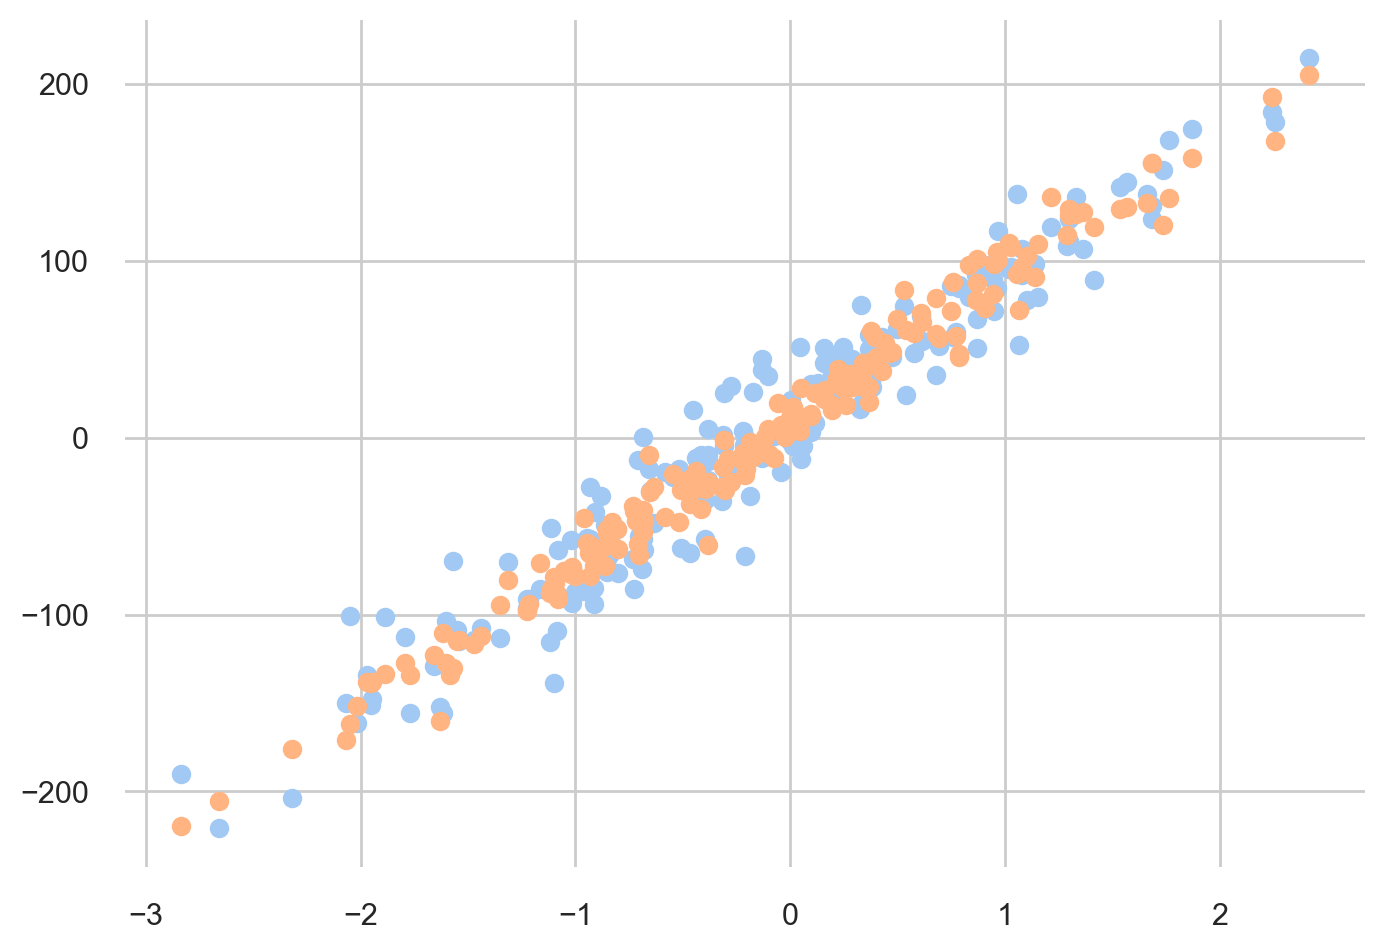

In [193]:
plt.scatter(X_test_reg,y_test_reg)
plt.scatter(X_test_reg,preds)
plt.savefig("reg_knn.png")

In [194]:
r2_score(y_test_reg, preds)

0.9231950126350865

In [195]:
root_mean_squared_error(y_test_reg, preds)

22.79793961569123